In [97]:
import torch
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import argparse
import matplotlib.pyplot as plt

In [91]:
embed = torch.load("./results/macosko_2015_labelled_20_h5ad/embed.pt").numpy()

In [92]:
cell_labels = []
with open("./results/macosko_2015_labelled_20_h5ad/00000/default/metadata.tsv") as handle:
    for line in handle.readlines():
        cell_labels.append(int(line.strip().split("-")[0]))

In [93]:
tsne = TSNE(verbose=1)

In [94]:
embed_transform = tsne.fit_transform(embed)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 44808 samples in 0.066s...
[t-SNE] Computed neighbors for 44808 samples in 119.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44808
[t-SNE] Computed conditional probabilities for sample 2000 / 44808
[t-SNE] Computed conditional probabilities for sample 3000 / 44808
[t-SNE] Computed conditional probabilities for sample 4000 / 44808
[t-SNE] Computed conditional probabilities for sample 5000 / 44808
[t-SNE] Computed conditional probabilities for sample 6000 / 44808
[t-SNE] Computed conditional probabilities for sample 7000 / 44808
[t-SNE] Computed conditional probabilities for sample 8000 / 44808
[t-SNE] Computed conditional probabilities for sample 9000 / 44808
[t-SNE] Computed conditional probabilities for sample 10000 / 44808
[t-SNE] Computed conditional probabilities for sample 11000 / 44808
[t-SNE] Computed conditional probabilities for sample 12000 / 44808
[t-SNE] Computed conditional probabilities for s

In [95]:
embed_df = pd.DataFrame(embed_transform)
embed_df.columns = ['tsne_one', 'tsne_two']
embed_df['cell_type'] = cell_labels

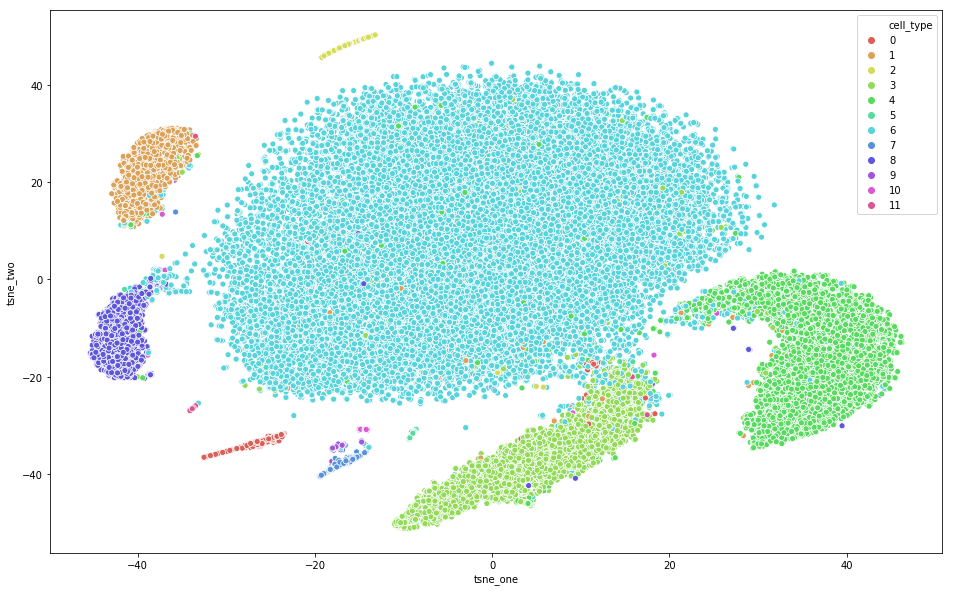

In [98]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='tsne_one', y='tsne_two',\
               data=embed_df, hue='cell_type',\
               palette=sns.color_palette("hls", 12))